This notebook analyzes two things:

1. Starting from a wealth distribution for which a completely balanced liquidity network is possible we look how the liquidity is distributed if economics from routing fees are respected (objective function is to maximize the fee potential of nodes)
2. In particular we observe how the liquidity distribution is affected with more circles being introduced to the network (e.g. a growing [circuit rank](https://en.wikipedia.org/wiki/Circuit_rank))

## Expected liquidity state for maximized fee potential

This notebook is an adoption of the observation that [the liquidity state of a network for a given wealth distribution can be estimated through solving a linear program](https://github.com/renepickhardt/Lightning-Network-Limitations/pull/2). This notebook assumes that every node owns on average half of its accessible capacity (which is certainly a feasible state) but then nodes try to allocate their liquidity in a way that maximizes the **fee potential** given through:

$\stackrel{max}{_{\lambda\in L_G}}\{\sum_{x\in e, e\in E}\lambda(e,x)\cdot ppm(e,x)\}$

The idea to maximize this function originated in a [private conversation](https://t.me/c/1249971199/73533) with [feelancer21](https://github.com/feelancer21). Feelancer21 calls this function the fee potential.

It is my understanding that a maximized fee potential is a reasonable state to assume as nodes that conduct payments will usually use cheap channels / routes. On the other side nodes that provide liquidity will probably raise the fees for their newly provided liquidity. I am not sure whether the global maximization of the fee potential is equivalent to the lack of negative cost cycles on the fee graph (assuming each node that searches for such offchain rebalancing cycles will set the respective fees to be negative). 

The first code block is an adoption of the code presented in [this pull request](https://github.com/renepickhardt/Lightning-Network-Limitations/pull/2). This utilizes the fact that a linear program can be solved to find a liquidity state. As we start with a wealth distribution that is certainly feasible we can now change the objective function to be the fee potential.

## Impact of cycles
The [paper in this repository (titled "A mathematical theory of payment channel networks")](https://github.com/renepickhardt/Lightning-Network-Limitations/blob/paper/Limits%20of%20two%20party%20channels/paper/a%20mathematical%20theory%20of%20payment%20channel%20networks.pdf) already describes that
* the cardinality of the preimage of a feasible wealth distribution is the same as the number of circulations on the associated liquidity network.
* liquidity in channels is uniformly distributed if the network is a tree (and feasibile wealth distributions are assumed to be uniform)

Additionally in a [recent paper](https://pubsonline.informs.org/doi/epdf/10.1287/mnsc.2023.03872) Paolo Guasoni Gur Huberman and Clara Shikhelman describe that lower clusting coefficients seem to lead to cost optimal topologies. In particular they prove that the cost optimal topology has to be bipartite. 

These two observations let one wonder how triangles and cycles on the Lightning Network together with economic decision making of its participants impact the emperical fact that many channels on the network are often depleted. We will see that even bipartite graphs will lead to depleted channels (noting our objective function is different to the one Guasoni et. al.)

## Known limitations

* It is not clear weather optimizing the fee potential is a reasonable model
* to be able to solve the ILP problems all graphs have been chosen to have only a few number of nodes

## Main Result

It seems as if the number of depleted channels that are in a depleted state if nodes allocate their liquidity in an economic rational way (by maximizing their fee potential) correlats extremly strongly - not to say perfectly - with the circuit rank of the network. Additionally there seems to be an almost spanning tree in which the liquidity seems to be distributed almost uniformly. 

## Open Question
We don't know yet how to predict which channels are expected to be depleted and which are part of the spanning tree
  
## Acknowledgements

Obviously a big thanks goes to feelancer21 who suggested after reading [a mathematical theory of payment channel networks](https://github.com/renepickhardt/Lightning-Network-Limitations/blob/paper/Limits%20of%20two%20party%20channels/paper/a%20mathematical%20theory%20of%20payment%20channel%20networks.pdf) that one could also study the liquidity state that maximizes the fee potential. The work is sponsored through a [grant from OpenSats](https://opensats.org/blog/rene-pickhardt-receives-lts-grant) and through [individual patreons](https://www.patreon.com/renepickhardt).

In [13]:
import networkx as nx
import random
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [413]:
def compute_expected_liquidity_distribution(gen, coins):
    """
    this code block is mainly taken from: 

    https://github.com/renepickhardt/Lightning-Network-Limitations/blob/sidiropoulos_counter_example/Limits%20of%20two%20party%20channels/From%20Wealth%20Distribution%20to%20a%20Channel%20State%20Vector.ipynb

    the main adoption is that the vector c contains the ppm of each channel
    """
    hist = []
    G = nx.Graph()
    for src,dest in gen.edges():
        l_s = int(coins[src]/nx.degree(gen,src))
        l_d = int(coins[dest]/nx.degree(gen,dest))
        fee_rate1 = random.randint(0,1000)
        if l_s < l_d:
            fee_rate2 = random.randint(0,fee_rate1)
        else:
            fee_rate2 = random.randint(0,1000)
            fee_rate1 = random.randint(0,fee_rate2)
            
        G.add_edge(src,dest,capacity =l_d+l_s, node1_policy={"fee_rate_milli_msat":fee_rate1},
                   node2_policy={"fee_rate_milli_msat":fee_rate2})
        #G.add_edge(src,dest,capacity =l_d+l_s, node1_policy={"fee_rate_milli_msat":1},
        #           node2_policy={"fee_rate_milli_msat":1})
    
    n = len(G.nodes())
    channels = {}
    c = []
    wealth = {i:0 for i in range(n)}
    key_to_idx = {}
    idx_to_key = {}
    #print(n)
    
    for src,dest,data in G.edges(data=True):
        #print(data)
        if data["node1_policy"] is not None and data["node2_policy"] is not None:
            cap = data["capacity"]
            if src not in key_to_idx:
                l = len(key_to_idx)
                key_to_idx[src] = l
                idx_to_key[l] = src
            if dest not in key_to_idx:
                l = len(key_to_idx)
                key_to_idx[dest] = l
                idx_to_key[l] = dest
            channels[(key_to_idx[src],key_to_idx[dest])] = cap
            try:
                c.append(-1*int(data["node1_policy"]["fee_rate_milli_msat"]))
                c.append(-1*int(data["node2_policy"]["fee_rate_milli_msat"]))
                if cap%2==0:
                    wealth[key_to_idx[src]]+=int(cap/2)
                    wealth[key_to_idx[dest]]+=int(cap/2)
                else:                
                    wealth[key_to_idx[src]]+=int((1.5+cap)/2)
                    wealth[key_to_idx[dest]]+=int(cap/2)
            except:
                print(src,dest,data)
    #len(channels), len(wealth), len(c), sum(wealth.values()), sum(channels.values())
    
    num_coins = sum(channels.values())
    m = len(channels)
    n = len(wealth)
    
    channel_idx = {}
    A = []
    b = []
    
    wealth_constraints = []
    for i in range(n):
        row = [0]*2*m
        wealth_constraints.append(row)
    
    bounds = []
    for k, chan in enumerate(channels.items()):
        row = [0]*2*m
        row[2*k]=1
        row[2*k+1]=1
        A.append(row)
        key,cap = chan
        #add bounds of channel twice as each channel adds two variables
        bounds.append((0,cap))
        bounds.append((0,cap))
    
        x,y = key
        channel_idx[2*k]=key
        channel_idx[2*k+1]=(y,x)
        
        wealth_constraints[x][2*k]=1
        wealth_constraints[y][2*k+1]=1
        b.append(cap)
    for k, row in enumerate(wealth_constraints):
        A.append(row)
        b.append(wealth[k])
    A.append([1]*2*m)
    num_coins=sum(wealth.values())
    b.append(num_coins)
    
    #print(A,b,bounds)
    #print_network(channels)
    res = linprog(c, A_eq=A, b_eq=b, bounds=bounds)
    #print(-res.fun, "= total fee potential")
    #print(res)
    
    H = nx.DiGraph()

    if res.success == True:
        #print("\nthis state vector satisfies the wealth distribution {}".format(wealth))
        total = 0

        for i,x in enumerate(res.x):
            src = idx_to_key[channel_idx[i][0]]
            dest = idx_to_key[channel_idx[i][1]]
            fee = -c[i]*x/1000_000
            total += fee
            #print(src,dest, x, "/", G[src][dest]["capacity"]," ppm: ",-c[i], fee, x/G[src][dest]["capacity"])
            #if src < dest:
            hist.append(x/G[src][dest]["capacity"])
            H.add_edge(src,dest,capacity=G[src][dest]["capacity"], usage=x, ppm = -c[i])
    else:
        print("\nThe wealth distribution {} is infeasible for the network".format(wealth))
    return hist, H


## Special case of equal capacity channels

We first study the case in which all channels are of equal capacity. We observe that in this case channels either fully deplete or stay perfectly balanced.
It is clear that in a tree the channels need to be balanced as that is the only feasible liquidity state for the wealth distribution that we started with. 
We assume that the fact thatin the powerlaw cluster some channels are not depleted relates to the fact that those channels are not members of circles

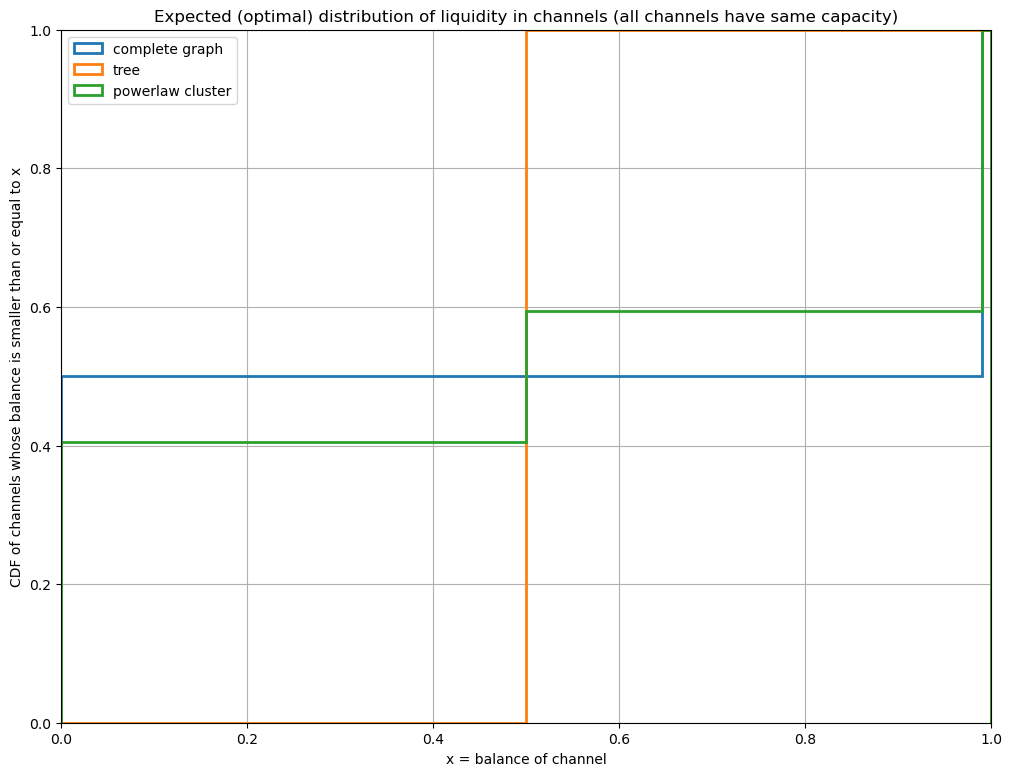

In [123]:

gen = nx.complete_graph(15)
coins = {i:0 for i in range(len(gen))}
for n in gen.nodes():
    coins[n]+=random.randint(nx.degree(gen,n)*100_000,nx.degree(gen,n)*100_000)
hist_complete, _  = compute_expected_liquidity_distribution(gen,coins)

gen = nx.full_rary_tree(4,50)
coins = {i:0 for i in range(len(gen))}
for n in gen.nodes():
    coins[n]+=random.randint(nx.degree(gen,n)*100_000,nx.degree(gen,n)*100_000)
hist_tree, _  = compute_expected_liquidity_distribution(gen,coins)

gen = nx.powerlaw_cluster_graph(100, 2, 0.8)
coins = {i:0 for i in range(len(gen))}
for n in gen.nodes():
    coins[n]+=random.randint(nx.degree(gen,n)*100_000,nx.degree(gen,n)*100_000)
hist_power, _  = compute_expected_liquidity_distribution(gen,coins)


plt.figure(figsize=(12,9))
plt.title("Expected (optimal) distribution of liquidity in channels (all channels have same capacity)")
plt.hist(hist_complete,bins=100,cumulative=True, density=True, histtype="step",linewidth=2,label="complete graph")
plt.hist(hist_tree,bins=100,cumulative=True, density=True, histtype="step",linewidth=2, label="tree")
plt.hist(hist_power,bins=100,cumulative=True, density=True, histtype="step",linewidth=2, label="powerlaw cluster")
plt.grid()
plt.legend()
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("x = balance of channel")
plt.ylabel("CDF of channels whose balance is smaller than or equal to x")
plt.show()

## A spanning tree of non depleted channels?

Given [prior research](https://github.com/gr-g/ln-steady-state-model/issues/1) we wonder if the fraction of balanced channels could somehow relate to size of a spanning tree within the network. 
Thus for various random networks we compute the liquidity distribution and count the number of non depleted channels and compare that number to the size of the spanning tree. 


In [373]:
hist = []
for j in range(10000):
    gen = nx.powerlaw_cluster_graph(random.randint(20,200), 2, 0.8)
    coins = {i:0 for i in range(len(gen))}
    for n in gen.nodes():
        coins[n]+=random.randint(nx.degree(gen,n)*100_000,nx.degree(gen,n)*100_000)
    hist_power, H  = compute_expected_liquidity_distribution(gen,coins)
    
    depleted = 0 
    for src,dest,data in H.edges(data=True):
        if data["usage"] == data["capacity"] or data["usage"]  == 0:
            depleted+=1
    
    n = len(H.nodes())
    m = len(H.edges())
    size_spaning_tree = n-1
    balanced = m - depleted
    ratio = balanced/size_spaning_tree
    hist.append(ratio)
    if j % 1000==0:
        print(j,np.median(hist))

0 0.7246376811594203
1000 0.7368421052631579
2000 0.7368421052631579
3000 0.7368421052631579
4000 0.7361963190184049
5000 0.7368421052631579
6000 0.7375
7000 0.7377049180327869
8000 0.7379679144385026
9000 0.738255033557047


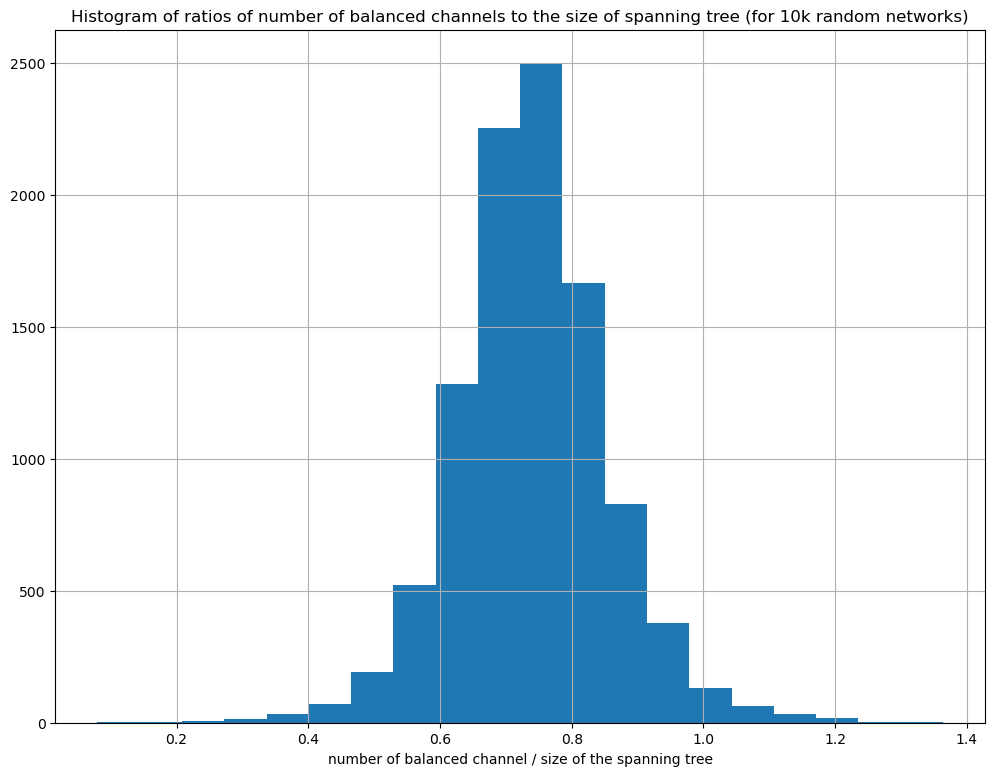

In [375]:
plt.figure(figsize=(12,9))
plt.title("Histogram of ratios of number of balanced channels to the size of spanning tree (for 10k random networks)")
plt.hist(hist,bins=20)
plt.xlabel("number of balanced channel / size of the spanning tree")
plt.ylabel("")
plt.grid()
plt.show()

## Impact of channel capacity

We now start to use channels of non equal size. This means that potential rebalancing circuits may not be fully executed as the smallest capacity channel yields a bottleneck. We expect that the result will look less binary. Of course trees should not be affected as according to the prior assumed wealth distributions the channels in the tree all have to be perfectly balanced

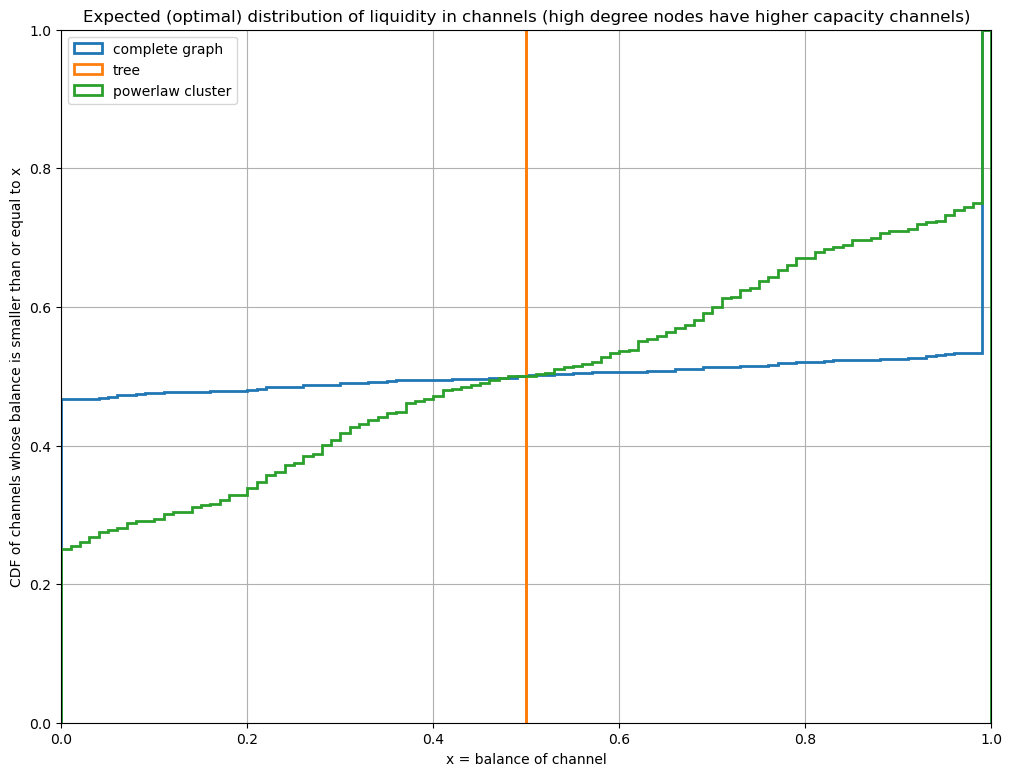

In [125]:
gen = nx.complete_graph(30)
coins = {i:0 for i in range(len(gen))}
for n in gen.nodes():
    coins[n]+=random.randint(nx.degree(gen,n)*1_000,nx.degree(gen,n)*100_000)
hist_complete, _  = compute_expected_liquidity_distribution(gen,coins)

gen = nx.full_rary_tree(4,50)
coins = {i:0 for i in range(len(gen))}
for n in gen.nodes():
    coins[n]+=random.randint(nx.degree(gen,n)*1_000,nx.degree(gen,n)*100_000)
hist_tree, _  = compute_expected_liquidity_distribution(gen,coins)

gen = nx.powerlaw_cluster_graph(100, 2, 0.8)
coins = {i:0 for i in range(len(gen))}
for n in gen.nodes():
    coins[n]+=random.randint(int((nx.degree(gen,n)*100_000)**1.1),int((nx.degree(gen,n)*100_000)**1.6))#random.randint(nx.degree(gen,n)*100_000,nx.degree(gen,n)*100_000)
hist_power, H  = compute_expected_liquidity_distribution(gen,coins)


plt.figure(figsize=(12,9))
plt.title("Expected (optimal) distribution of liquidity in channels (high degree nodes have higher capacity channels)")
plt.hist(hist_complete,bins=100,cumulative=True, density=True, histtype="step",linewidth=2,label="complete graph")
plt.hist(hist_tree,bins=100,cumulative=True, density=True, histtype="step",linewidth=2, label="tree")
plt.hist(hist_power,bins=100,cumulative=True, density=True, histtype="step",linewidth=2, label="powerlaw cluster")
plt.grid()
plt.legend()
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("x = balance of channel")
plt.ylabel("CDF of channels whose balance is smaller than or equal to x")
plt.show()

## Clustering Coefficients, Cycles and Bipartite Graphs

when changing the optimization objective to minimize the global cost of the network it was shown in recent research that a cost optimal network has to be bipartite. That research also showed emperically that the clustering coefficient on the network is decreasing over time. This hints that the network's participants are becoming smarter in their decision making. As the clustering coefficient measures the existance of circles of length 3 and since we discovered that the existance of circles seem to have an impact for channels to deplete we continue our experiments. We study if there is a connection between

* clustering coefficient / number of depleted channels
* number of circles / number of depleted channels

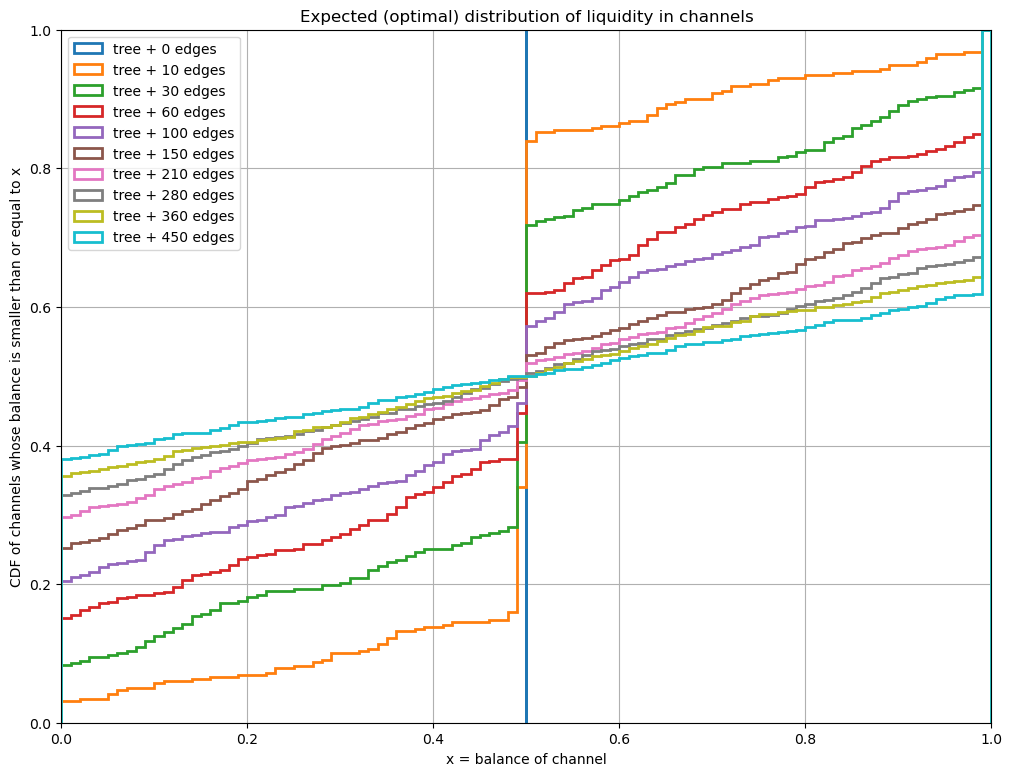

In [426]:
cluster_coeffs = []
depelted_channels = []
for j in range(5):
    gen = nx.full_rary_tree(4,150)
    hist = {i:[] for i in range(14)}
    for i in range(14):
        coins = {i:0 for i in range(len(gen))}
        for n in gen.nodes():
            coins[n]+=random.randint(nx.degree(gen,n)*10_000,nx.degree(gen,n)*100_000)
        h, X  = compute_expected_liquidity_distribution(gen,coins)
        clustering = nx.average_clustering(X)
        fraction_of_depleted_channels = len([1 for x in h if abs(x-0.5) > 0.48])/len(h)
        #print(clustering, fraction_of_depleted_channels)
        cluster_coeffs.append(clustering)
        depelted_channels.append(fraction_of_depleted_channels)
        hist[i] = h
        cnt = 0
        while True:
            nodes=list(gen.nodes())
            src, dest = random.sample(nodes,2)
            if dest not in gen[src]:
                cnt+=1
                gen.add_edge(src,dest)
                if cnt >=10*(i+1):
                    break

plt.figure(figsize=(12,9))
plt.title("Expected (optimal) distribution of liquidity in channels")
total = 0
for i in range(10):
    total +=i*10
    plt.hist(hist[i],bins=100,cumulative=True, density=True, histtype="step",linewidth=2,label="tree + {} edges".format(total))
    #print(len(hist[i])/2,total)
plt.grid()
plt.legend()
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("x = balance of channel")
plt.ylabel("CDF of channels whose balance is smaller than or equal to x")
plt.show()

### Relation to clustering coefficient

we plot the fraction of depleted channels in comparison to the clustering coefficient. This is heavily motivated by recent research on LN economics 

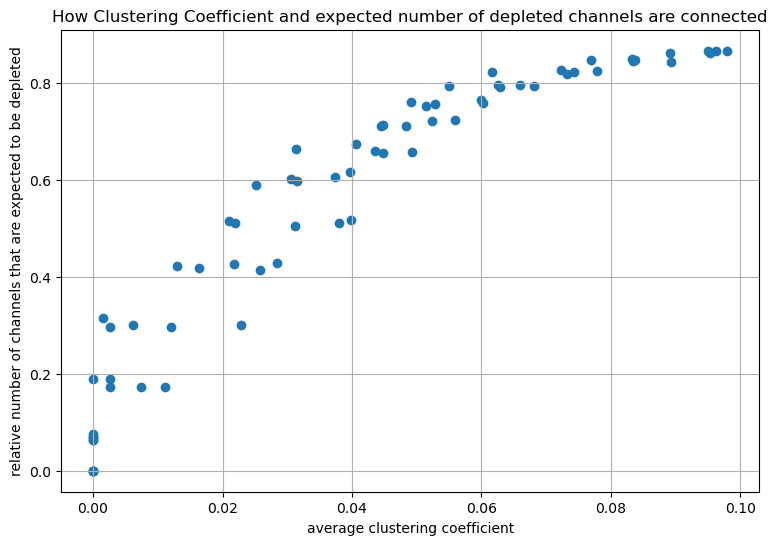

In [418]:
plt.figure(figsize=(9,6))
plt.title("How Clustering Coefficient and expected number of depleted channels are connected")
plt.scatter(cluster_coeffs,depelted_channels)
plt.xlabel("average clustering coefficient")
plt.ylabel("relative number of channels that are expected to be depleted")
#plt.xscale("log")
plt.grid()
plt.show()

## Looking at the effect of bipartite graphs

in a recent research co authored by Clara Shirkleman it was pointed out that [high clustering coefficients are non cost optimal. In particular circles of odd length are not cost optimal and thus a cost optimal topology needs to be a bipartite graph](https://pubsonline.informs.org/doi/10.1287/mnsc.2023.03872)! Thus it makes sense to add bipartite graphs to the study. 

For this we add a bipartite graph that has roughly the same number of edges as the power law cluster graph that we generated before.


0.0784
0.0
388


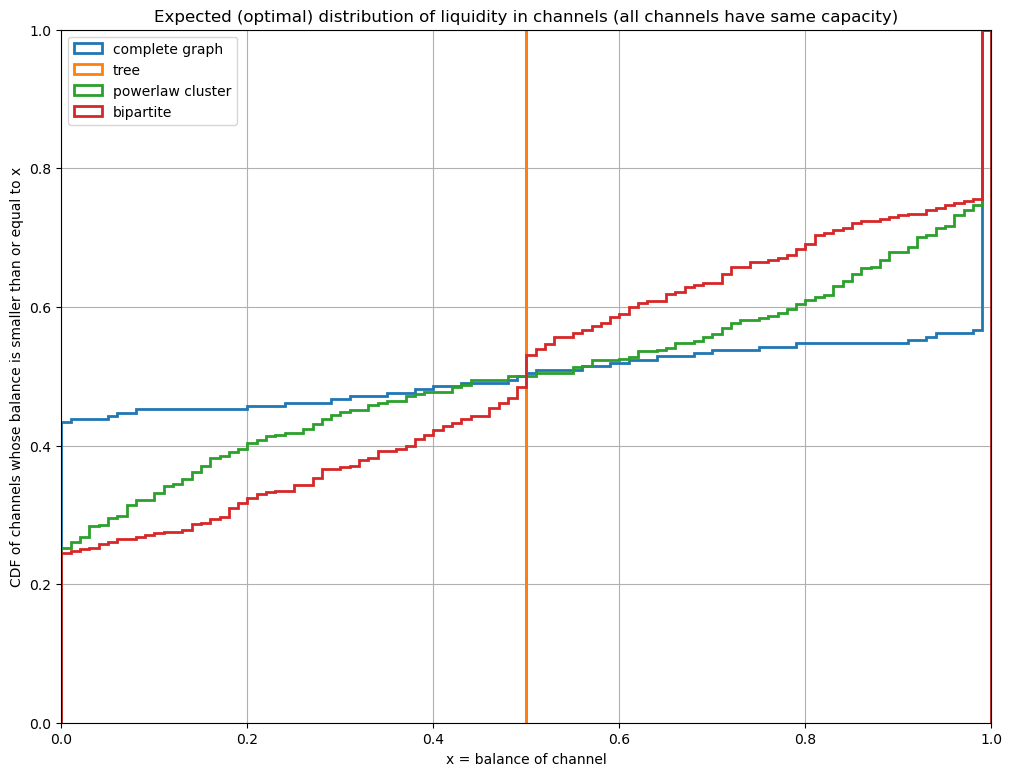

In [435]:

gen = nx.complete_graph(15)
coins = {i:0 for i in range(len(gen))}
for n in gen.nodes():
    coins[n]+=random.randint(nx.degree(gen,n)*100_000,nx.degree(gen,n)*1000_000)
hist_complete, _  = compute_expected_liquidity_distribution(gen,coins)

gen = nx.full_rary_tree(4,50)
coins = {i:0 for i in range(len(gen))}
for n in gen.nodes():
    coins[n]+=random.randint(nx.degree(gen,n)*100_000,nx.degree(gen,n)*1000_000)
hist_tree, _  = compute_expected_liquidity_distribution(gen,coins)

gen = nx.powerlaw_cluster_graph(100, 2, 0.8)
coins = {i:0 for i in range(len(gen))}
for n in gen.nodes():
    coins[n]+=random.randint(nx.degree(gen,n)*100_000,nx.degree(gen,n)*1000_000)
hist_power, G  = compute_expected_liquidity_distribution(gen,coins)
ratio = float(len(G.edges))/(len(G)*(len(G))/2) 
print(ratio)

gen = nx.bipartite.random_graph(50,50,ratio)
coins = {i:0 for i in range(len(gen))}
for n in gen.nodes():
    coins[n]+=random.randint(nx.degree(gen,n)*100_000,nx.degree(gen,n)*1000_000)
hist_bipartite, H  = compute_expected_liquidity_distribution(gen,coins)
clustering = nx.average_clustering(H)
print(clustering)

ratio = float(len(H.edges))/(len(H)**2) 
print(len(H.edges()))

plt.figure(figsize=(12,9))
plt.title("Expected (optimal) distribution of liquidity in channels (all channels have same capacity)")
plt.hist(hist_complete,bins=100,cumulative=True, density=True, histtype="step",linewidth=2,label="complete graph")
plt.hist(hist_tree,bins=100,cumulative=True, density=True, histtype="step",linewidth=2, label="tree")
plt.hist(hist_power,bins=100,cumulative=True, density=True, histtype="step",linewidth=2, label="powerlaw cluster")
plt.hist(hist_bipartite,bins=100,cumulative=True, density=True, histtype="step",linewidth=2, label="bipartite")

plt.grid()
plt.legend()
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("x = balance of channel")
plt.ylabel("CDF of channels whose balance is smaller than or equal to x")
plt.show()

we still see about the same amout of channels being depleted as in the power law cluster model. But:

## Bipartite graphs have clustering coefficient of 0

Thus it does not make sense to look at the fraction of depleted channels against the cluster coefficient. Let us stick at circles which can be estimated via circuit rank or the number of edges in the graph

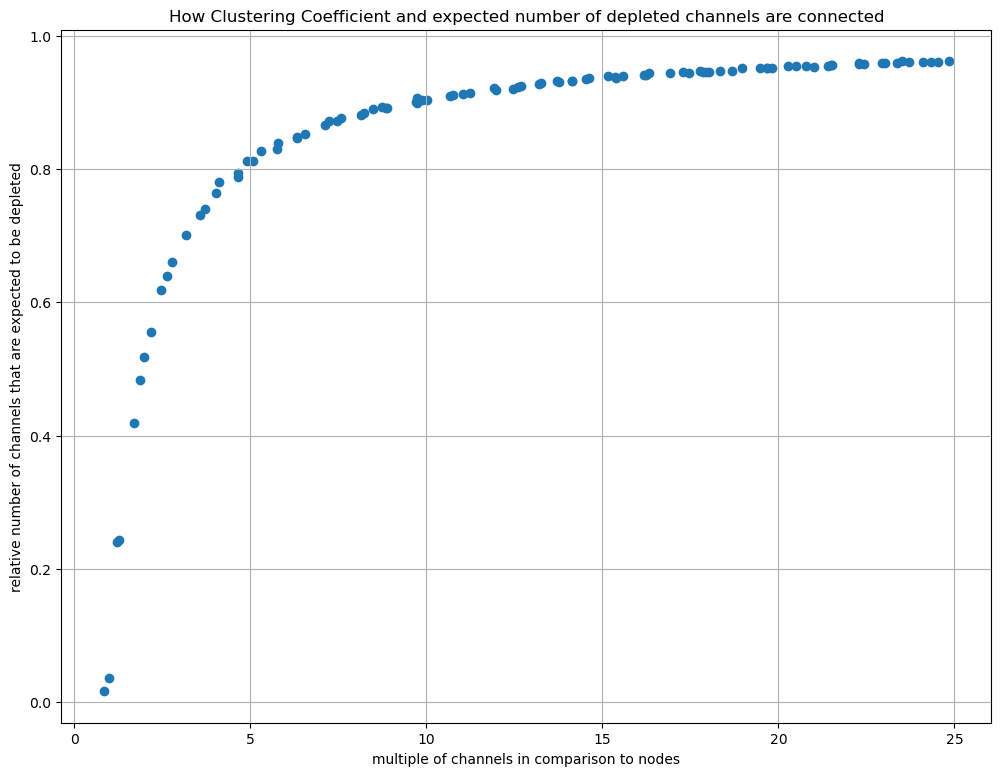

In [469]:
xs = []
ys = []
cycles = []
depleted_channels = []
for i in range(2,100):
    ratio = 0.01*i
    gen = nx.bipartite.random_graph(50,50,ratio)
    coins = {i:0 for i in range(len(gen))}
    for n in gen.nodes():
        coins[n]+=random.randint(nx.degree(gen,n)*100_000,nx.degree(gen,n)*1000_000)
    h, X  = compute_expected_liquidity_distribution(gen,coins)
    edge_multiple = len(X.edges())/2/len(X.nodes())#nx.average_clustering(X)
    number_of_depleted_channels = len([1 for x in h if abs(x-0.5) > 0.48])
    fraction_of_depleted_channels = number_of_depleted_channels / len(h)
    #cb = len(nx.cycle_basis(gen))
    cr = len(gen.edges()) - len(gen.nodes) + nx.number_connected_components(gen)
    #print(clustering, fraction_of_depleted_channels, nx.average_clustering(X),cr)
    xs.append(edge_multiple)
    ys.append(fraction_of_depleted_channels)
    cycles.append(cr)
    depleted_channels.append(number_of_depleted_channels/2)

#plt.scatter(xs,ys)
#plt.grid()
#plt.show()

plt.figure(figsize=(12,9))
plt.title("How Clustering Coefficient and expected number of depleted channels are connected")
plt.scatter(xs,ys)
plt.xlabel("multiple of channels in comparison to nodes")
plt.ylabel("relative number of channels that are expected to be depleted")
#plt.xscale("log")
plt.grid()
plt.show()


## Let us look at the absolute numbers of cycles & depleted channels

In [475]:
linregress(cycles, depleted_channels)

LinregressResult(slope=1.0003706259436551, intercept=3.303618086106326, rvalue=0.9999962073967619, pvalue=1.4062777892765207e-247, stderr=0.0002811967218156029, intercept_stderr=0.3830885654206334)

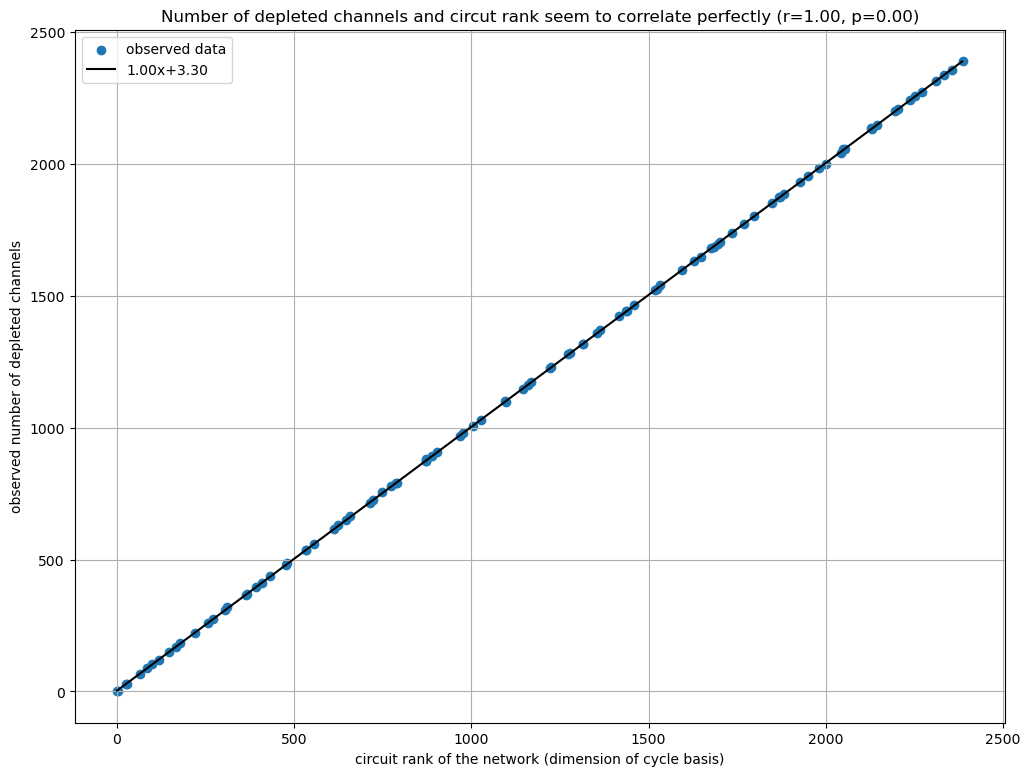

In [485]:

slope, intercept, rvalue, pvalue, stderr = linregress(cycles, depleted_channels)

plt.figure(figsize=(12,9))
plt.title("Number of depleted channels and circut rank seem to correlate perfectly (r={:4.2f}, p={:4.2f})".format(rvalue,pvalue))
plt.scatter(cycles,depleted_channels,label="observed data")
x_values = [i for i in range(max(cycles))]
plt.plot(x_values,[slope*x+intercept for x in x_values],"k-",label="{:4.2f}x+{:4.2f}".format(slope,intercept))
plt.xlabel("circuit rank of the network (dimension of cycle basis)")
plt.ylabel("observed number of depleted channels")
plt.legend()
plt.grid()
plt.show()

## OLD experiments / Backup

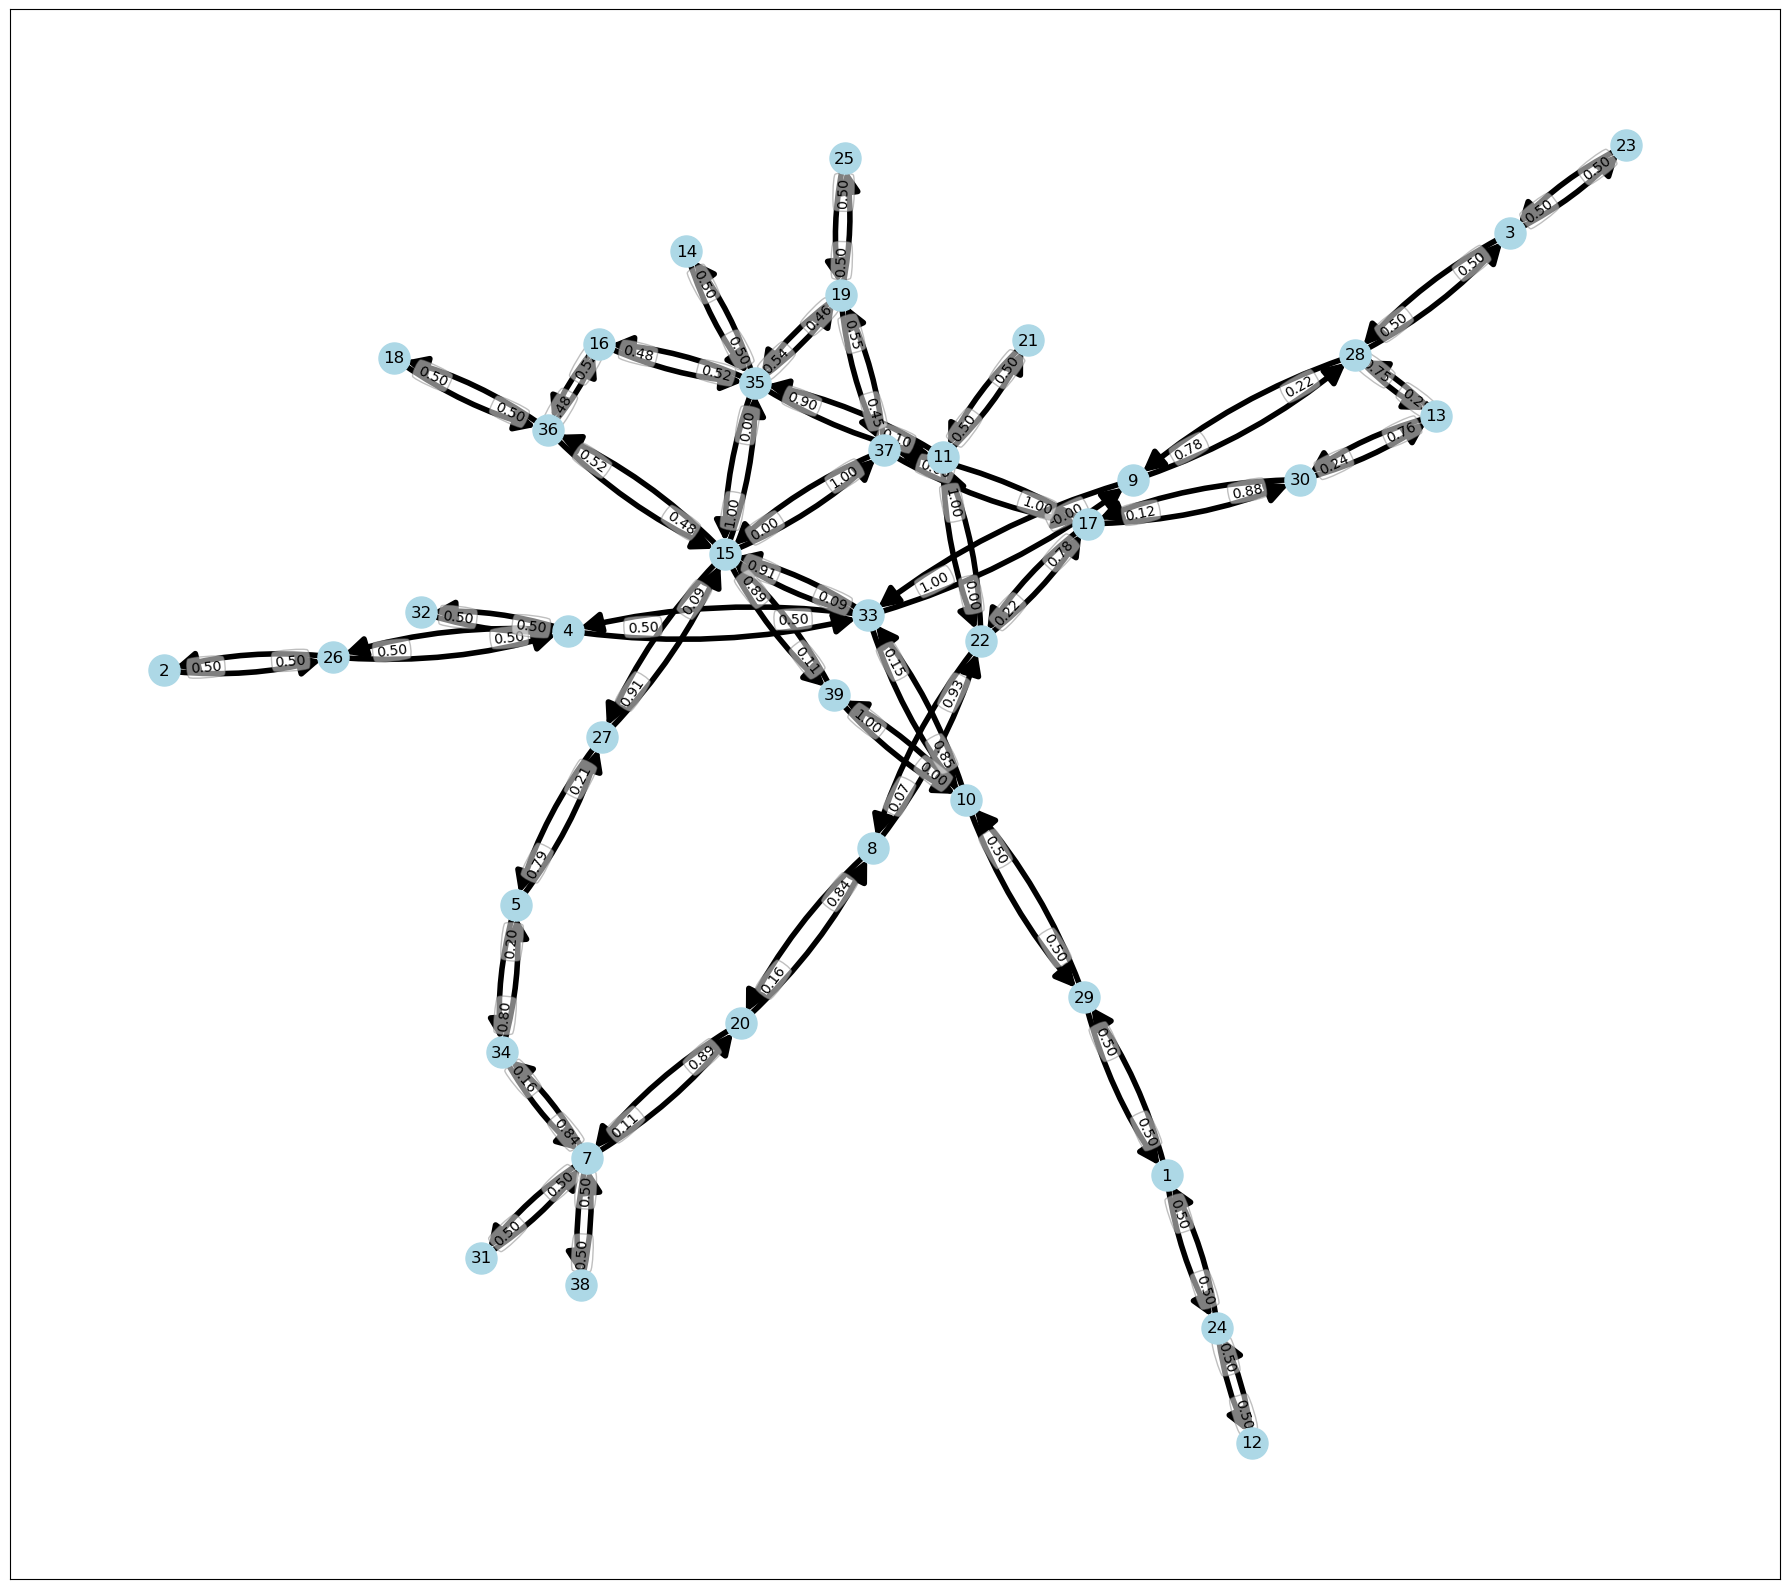

In [207]:
plt.figure(figsize=(18, 16))
pos = nx.spring_layout(H)
#print(pos)

# Draw nodes and edges
nx.draw_networkx_nodes(H, pos, node_size=500, node_color='lightblue')
edges = nx.draw_networkx_edges(H, pos, width=4.0, arrowsize=30, connectionstyle="arc3,rad=0.1")  # Adjust curvature with "rad"

# Label nodes and edges
nx.draw_networkx_labels(H, pos, font_size=12)

# Add edge labels with capacity, usage, and ppm
labels = {}
for edge in H.edges():
    capacity = H[edge[0]][edge[1]]['capacity']
    usage = H[edge[0]][edge[1]]['usage']
    ppm = H[edge[0]][edge[1]]['ppm']
    #labels[edge] = f"Capacity: {capacity}\nUsage: {usage}\nPPM: {ppm}"
    labels[edge] = "{:4.2f} {}ppm".format(usage/capacity,ppm)
    labels[edge] = "{:4.2f}".format(usage/capacity)


#nx.draw_networkx_edge_labels(G, pos, labels=labels, font_size=8, bbox=dict(boxstyle="round4", fc="white", ec="gray", alpha=0.5), connectionstyle="arc3,rad=0.2")  # Adjust curvature with "rad"
nx.draw_networkx_edge_labels(H, pos, edge_labels=labels, font_size=10, bbox=dict(boxstyle="round4", fc="white", ec="gray", alpha=0.5), 
                             label_pos = 0.25,rotate=True)
#nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8, bbox=dict(boxstyle="round4", fc="white", ec="gray", alpha=0.5))

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

OMG! I accidentally measured something that I did not wish to measure and the result is crazy?

In [ ]:
import pulp
import glpk

In [447]:
#!pip install ripser

In [ ]:
    """    
    G.add_edge("B","C",capacity=random.randint(100_000,1000_000),node1_policy={"fee_rate_milli_msat":random.randint(0,1000)},node2_policy={"fee_rate_milli_msat":random.randint(0,1000)})
    G.add_edge("A","B",capacity=random.randint(100_000,1000_000),node1_policy={"fee_rate_milli_msat":random.randint(0,1000)},node2_policy={"fee_rate_milli_msat":random.randint(0,1000)})
    G.add_edge("C","A",capacity=random.randint(100_000,1000_000),node1_policy={"fee_rate_milli_msat":random.randint(0,1000)},node2_policy={"fee_rate_milli_msat":random.randint(0,1000)})
    G.add_edge("A","D",capacity=random.randint(100_000,1000_000),node1_policy={"fee_rate_milli_msat":random.randint(0,1000)},node2_policy={"fee_rate_milli_msat":random.randint(0,1000)})
    G.add_edge("B","D",capacity=random.randint(100_000,1000_000),node1_policy={"fee_rate_milli_msat":random.randint(0,1000)},node2_policy={"fee_rate_milli_msat":random.randint(0,1000)})
    G.add_edge("E","D",capacity=random.randint(100_000,1000_000),node1_policy={"fee_rate_milli_msat":random.randint(0,1000)},node2_policy={"fee_rate_milli_msat":random.randint(0,1000)})
    G.add_edge("E","A",capacity=random.randint(100_000,1000_000),node1_policy={"fee_rate_milli_msat":random.randint(0,1000)},node2_policy={"fee_rate_milli_msat":random.randint(0,1000)})
    G.add_edge("B","F",capacity=random.randint(100_000,1000_000),node1_policy={"fee_rate_milli_msat":random.randint(0,1000)},node2_policy={"fee_rate_milli_msat":random.randint(0,1000)})
    G.add_edge("E","F",capacity=random.randint(100_000,1000_000),node1_policy={"fee_rate_milli_msat":random.randint(0,1000)},node2_policy={"fee_rate_milli_msat":random.randint(0,1000)})
    G.add_edge("E","G",capacity=random.randint(100_000,1000_000),node1_policy={"fee_rate_milli_msat":random.randint(0,1000)},node2_policy={"fee_rate_milli_msat":random.randint(0,1000)})
    G.add_edge("C","G",capacity=random.randint(100_000,1000_000),node1_policy={"fee_rate_milli_msat":random.randint(0,1000)},node2_policy={"fee_rate_milli_msat":random.randint(0,1000)})
    G.add_edge("A","H",capacity=random.randint(100_000,1000_000),node1_policy={"fee_rate_milli_msat":random.randint(0,1000)},node2_policy={"fee_rate_milli_msat":random.randint(0,1000)})
    G.add_edge("H","D",capacity=random.randint(100_000,1000_000),node1_policy={"fee_rate_milli_msat":random.randint(0,1000)},node2_policy={"fee_rate_milli_msat":random.randint(0,1000)})
    """



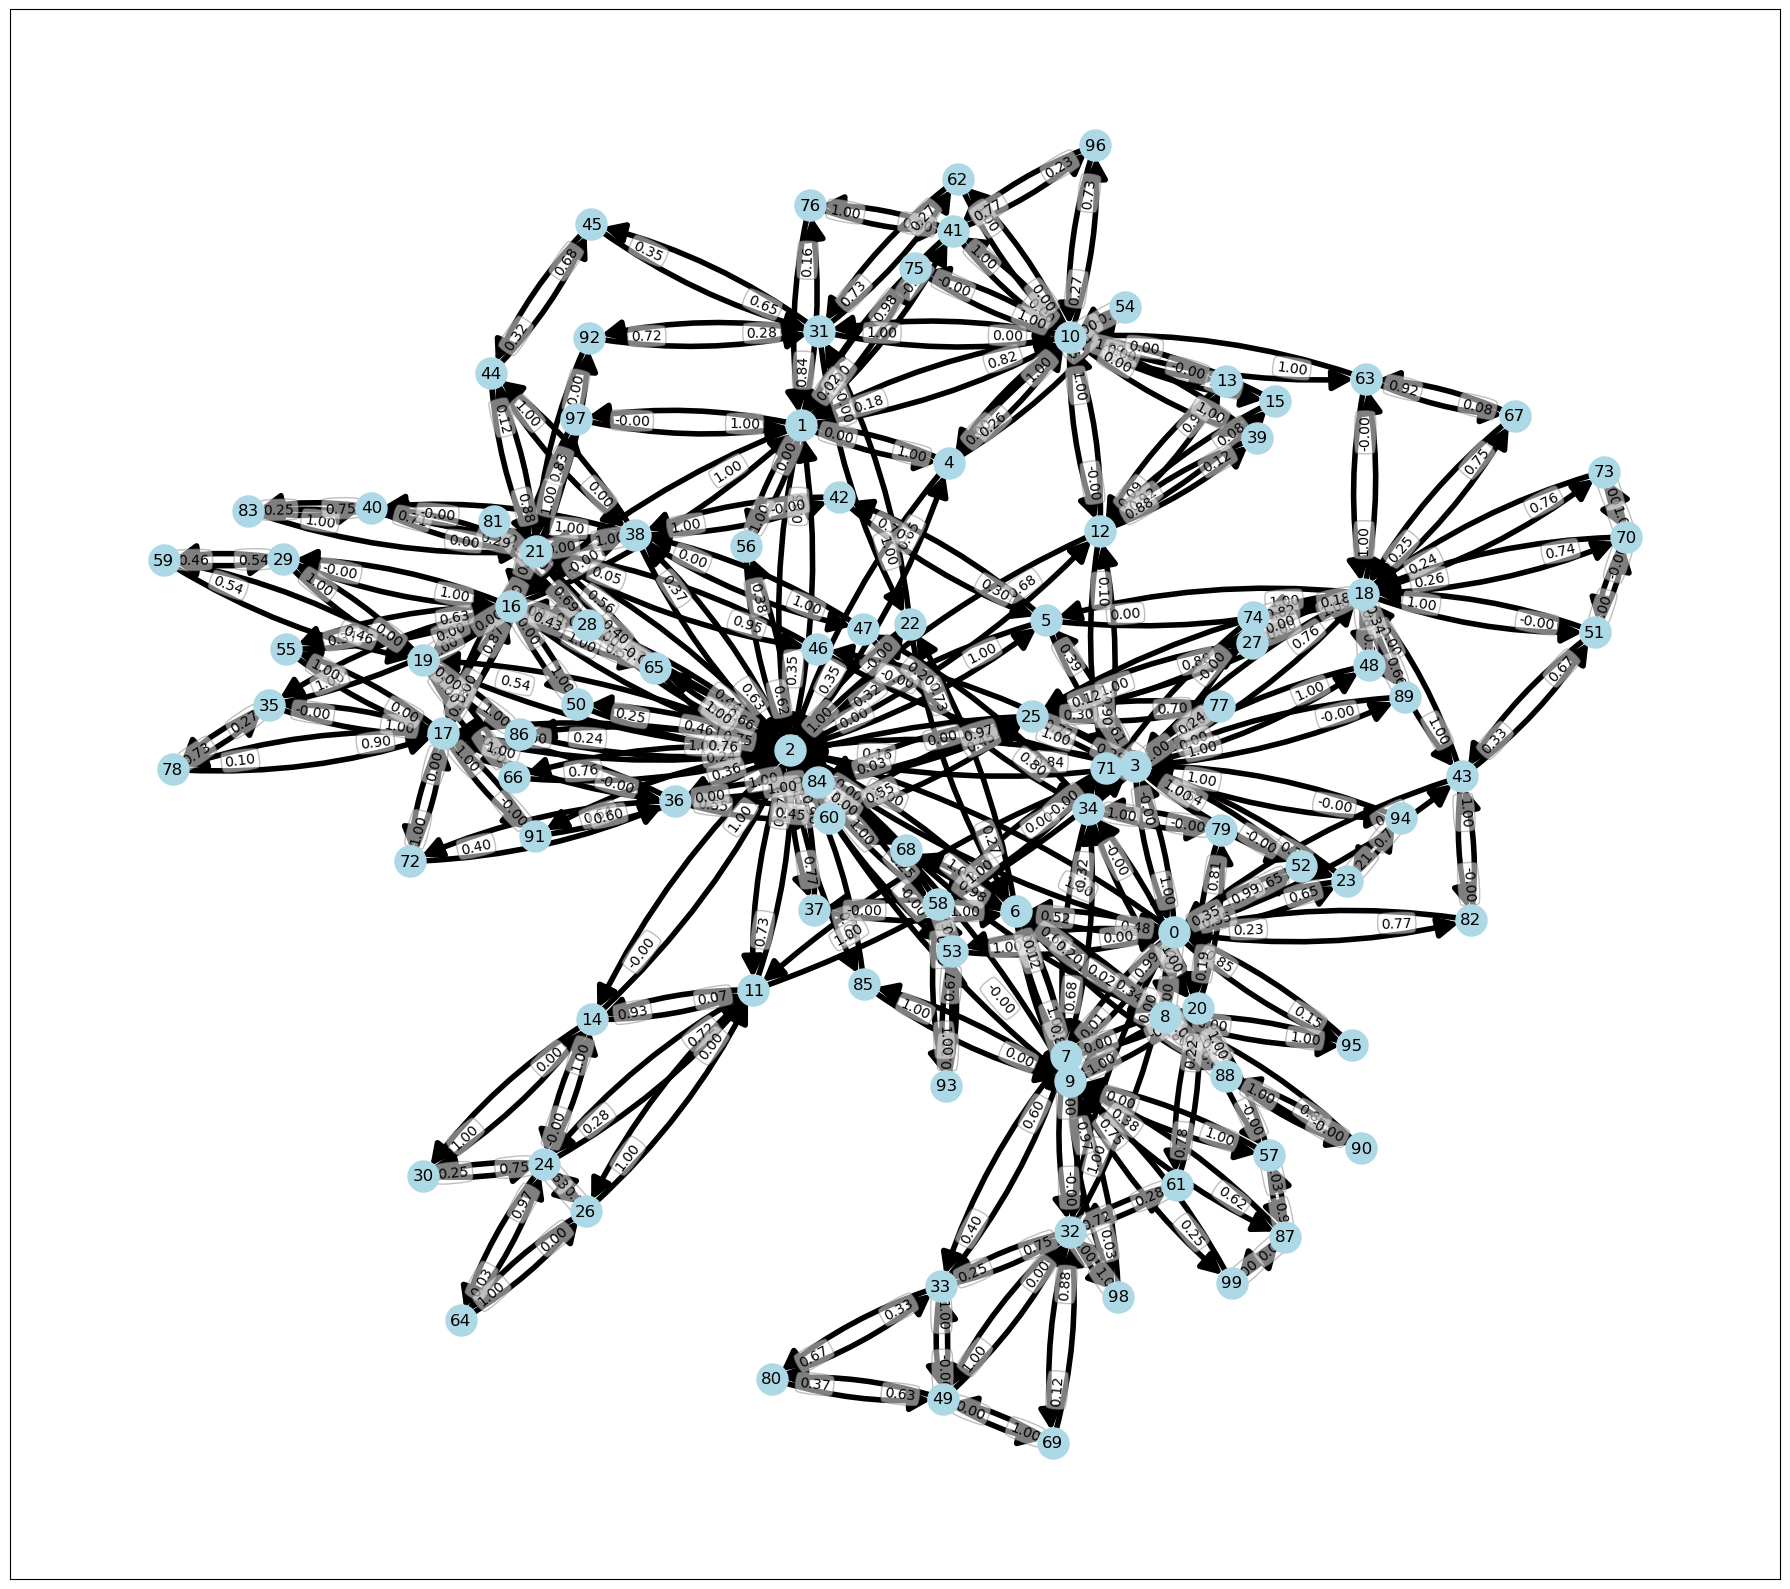

In [52]:
plt.figure(figsize=(18, 16))
pos = nx.spring_layout(H)
#print(pos)

# Draw nodes and edges
nx.draw_networkx_nodes(H, pos, node_size=500, node_color='lightblue')
edges = nx.draw_networkx_edges(H, pos, width=4.0, arrowsize=30, connectionstyle="arc3,rad=0.1")  # Adjust curvature with "rad"

# Label nodes and edges
nx.draw_networkx_labels(H, pos, font_size=12)

# Add edge labels with capacity, usage, and ppm
labels = {}
for edge in H.edges():
    capacity = H[edge[0]][edge[1]]['capacity']
    usage = H[edge[0]][edge[1]]['usage']
    ppm = H[edge[0]][edge[1]]['ppm']
    #labels[edge] = f"Capacity: {capacity}\nUsage: {usage}\nPPM: {ppm}"
    labels[edge] = "{:4.2f} {}ppm".format(usage/capacity,ppm)
    labels[edge] = "{:4.2f}".format(usage/capacity)


#nx.draw_networkx_edge_labels(G, pos, labels=labels, font_size=8, bbox=dict(boxstyle="round4", fc="white", ec="gray", alpha=0.5), connectionstyle="arc3,rad=0.2")  # Adjust curvature with "rad"
nx.draw_networkx_edge_labels(H, pos, edge_labels=labels, font_size=10, bbox=dict(boxstyle="round4", fc="white", ec="gray", alpha=0.5), 
                             label_pos = 0.25,rotate=True)
#nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8, bbox=dict(boxstyle="round4", fc="white", ec="gray", alpha=0.5))

# Adjust layout and display the plot
plt.tight_layout()
plt.show()